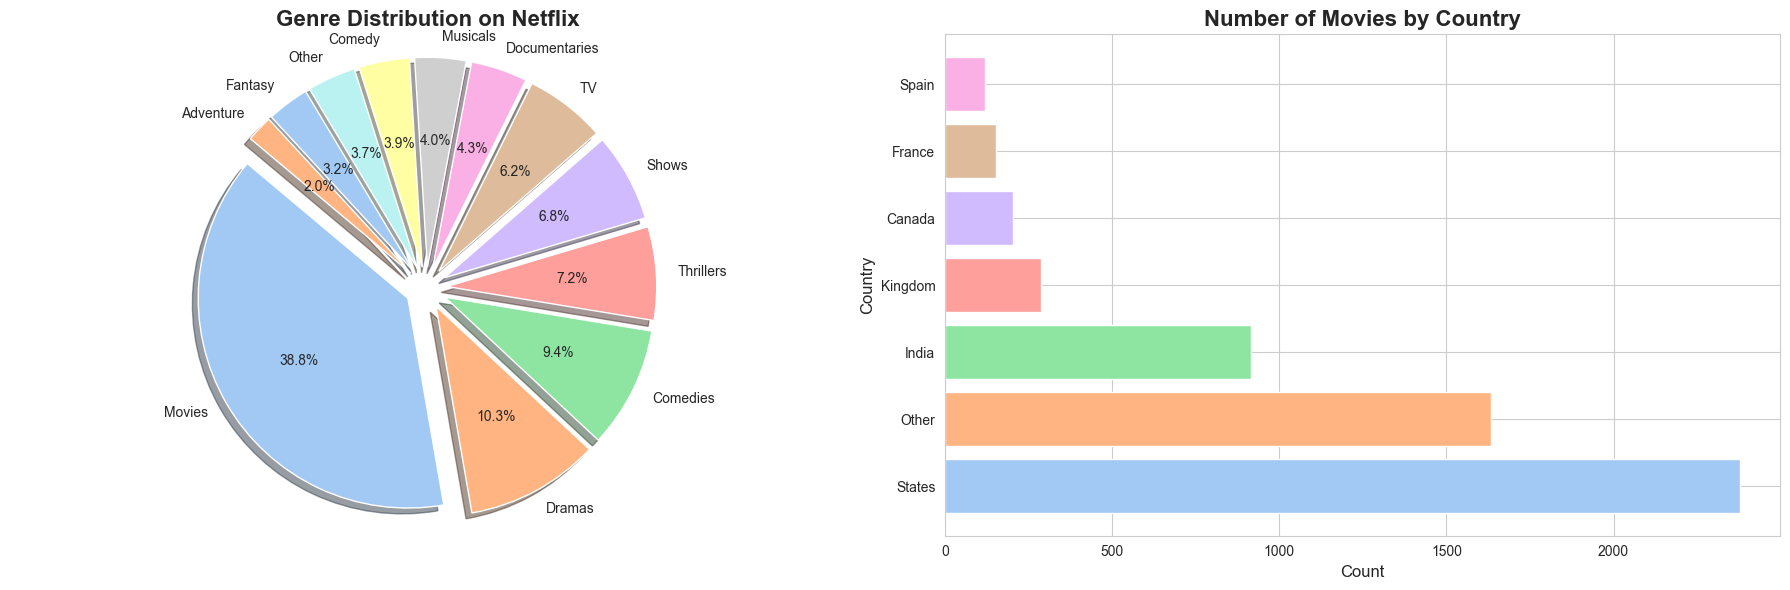

In [28]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set_style("whitegrid")

# Load the CSV into a Pandas DataFrame
netflix_df = pd.read_csv('netflix_titles.csv')

# Connect to a SQLite database (or create one if it doesn't exist)
conn = sqlite3.connect('netflix.db')

# Write the DataFrame to a SQLite table
netflix_df.to_sql('netflix_titles', conn, if_exists='replace', index=False)

# Execute SQL query to select data for genre distribution
genre_query = """
SELECT SUBSTR(listed_in, INSTR(listed_in, ' ') + 1) AS genre, COUNT(*) AS count
FROM netflix_titles
GROUP BY genre
ORDER BY count DESC
"""

# Fetch the results into a DataFrame for genre distribution
genre_counts_df = pd.read_sql(genre_query, conn)

# Combine the same last words in the category for genre distribution
genre_counts_df['last_word'] = genre_counts_df['genre'].apply(lambda x: x.split()[-1])
combined_genre_counts_df = genre_counts_df.groupby('last_word')['count'].sum().reset_index()

# Calculate the total count for genre distribution
total_genre_count = combined_genre_counts_df['count'].sum()

# Threshold for genres below 2% for genre distribution
genre_threshold = 0.02 * total_genre_count

# Filter genres below the threshold and combine them into "Other" for genre distribution
other_genre_count = combined_genre_counts_df[combined_genre_counts_df['count'] < genre_threshold]['count'].sum()
combined_genre_counts_df = combined_genre_counts_df[combined_genre_counts_df['count'] >= genre_threshold]
combined_genre_counts_df.loc[len(combined_genre_counts_df)] = ['Other', other_genre_count]

# Sort the DataFrame by count in descending order for genre distribution
combined_genre_counts_df = combined_genre_counts_df.sort_values(by='count', ascending=False)

# Execute SQL query to select data for country distribution
country_query = """
SELECT country, COUNT(*) AS count
FROM netflix_titles
WHERE type = 'Movie' AND country IS NOT NULL
GROUP BY country
ORDER BY count DESC
"""

# Fetch the results into a DataFrame for country distribution
country_counts_df = pd.read_sql(country_query, conn)

# Combine the same last words in the country names for country distribution
country_counts_df['last_word'] = country_counts_df['country'].apply(lambda x: x.split()[-1])
combined_country_counts_df = country_counts_df.groupby('last_word')['count'].sum().reset_index()

# Calculate the total count for country distribution
total_country_count = combined_country_counts_df['count'].sum()

# Threshold for countries below 2% for country distribution
country_threshold = 0.02 * total_country_count

# Filter countries below the threshold and combine them into "Other" for country distribution
other_country_count = combined_country_counts_df[combined_country_counts_df['count'] < country_threshold]['count'].sum()
combined_country_counts_df = combined_country_counts_df[combined_country_counts_df['count'] >= country_threshold]
combined_country_counts_df.loc[len(combined_country_counts_df)] = ['Other', other_country_count]

# Sort the DataFrame by count in descending order for country distribution
combined_country_counts_df = combined_country_counts_df.sort_values(by='count', ascending=False)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Pie chart for genre distribution
axes[0].set_title('Genre Distribution on Netflix', fontsize=16, fontweight='bold')
colors = sns.color_palette('pastel')[0:len(combined_genre_counts_df)]
explode = [0.1] * len(combined_genre_counts_df)  # Explode all slices slightly
axes[0].pie(combined_genre_counts_df['count'], labels=combined_genre_counts_df['last_word'], autopct='%1.1f%%', startangle=140, colors=colors, explode=explode, shadow=True)
axes[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Bar chart for country distribution
axes[1].barh(combined_country_counts_df['last_word'], combined_country_counts_df['count'], color=sns.color_palette('pastel'))
axes[1].set_title('Number of Movies by Country', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Count', fontsize=12)
axes[1].set_ylabel('Country', fontsize=12)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Save the visualizations as PNG files
plt.savefig('genre_distribution.png', bbox_inches='tight')
plt.savefig('country_distribution.png', bbox_inches='tight')

plt.show()
